Se genera para cada mes del archivo ERA5

**Codigo nuevo para cada mes**

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgeos-dev is already the newest version (3.11.1-1~jammy0).
libproj-dev is already the newest version (9.1.1-1~jammy0).
proj-bin is already the newest version (9.1.1-1~jammy0).
proj-data is already the newest version (9.1.1-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Shapefile cargado exitosamente: shapefiles/departamentos.shp
Shapefile graficado correctamente.


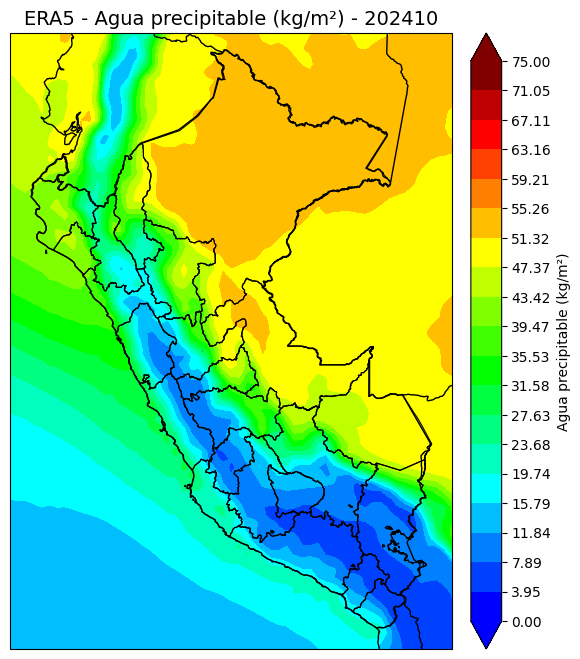

In [12]:
# Instalar Cartopy, GeoPandas y otras dependencias en Google Colab
!apt-get install -y libproj-dev proj-data proj-bin libgeos-dev
!pip install cython
!pip install cartopy cfgrib geopandas matplotlib pandas

import os
import requests
import cfgrib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pandas as pd
import cartopy.feature as cfeature  # Importar cartopy.feature como cfeature

# Fecha inicial
FECHA_INICIAL = "202410"

# Función para descargar archivos
def download_file(url, local_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(local_path, "wb") as f:
            f.write(response.content)
        print(f"Descargado: {local_path}")
    else:
        print(f"Error al descargar {url}: Código {response.status_code}")

# Descarga de shapefiles
shapefiles = {
    "departamentos.shp": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.shp",
    "departamentos.dbf": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.dbf",
    "departamentos.shx": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.shx",
}

# Crear carpeta para guardar los shapefiles
os.makedirs("shapefiles", exist_ok=True)

# Descargar cada archivo
for name, url in shapefiles.items():
    local_path = os.path.join("shapefiles", name)
    if not os.path.exists(local_path):
        response = requests.get(url)
        if response.status_code == 200:
            with open(local_path, "wb") as f:
                f.write(response.content)
            print(f"Descargado: {local_path}")
        else:
            print(f"Error al descargar {url}: Código {response.status_code}")

# Ruta local del shapefile
shapefile_path = "shapefiles/departamentos.shp"

# Cargar shapefile usando GeoPandas
try:
    gdf = gpd.read_file(shapefile_path)
    print(f"Shapefile cargado exitosamente: {shapefile_path}")
except Exception as e:
    print(f"Error al cargar el shapefile: {e}")

# Ruta del archivo GRIB
grib_url = f'https://raw.githubusercontent.com/Jorgellamocca/ERA5/main/data/flx_era5_{FECHA_INICIAL}.grib'
grib_path = f"era5_{FECHA_INICIAL}.grib"

# Descargar archivo GRIB si no existe
if not os.path.exists(grib_path):
    download_file(grib_url, grib_path)

# Abrir archivo GRIB
ds = cfgrib.open_dataset(grib_path)

# Extraer datos
lons = ds.longitude.values
lats = ds.latitude.values
prw = ds.tcw.values  # Agua precipitable

# Crear mapa de colores
colors = ["#0000ff", "#0040ff", "#0080ff", "#00bfff", "#00ffff",
          "#00ffbf", "#00ff80", "#00ff40", "#00ff00", "#40ff00",
          "#80ff00", "#bfff00", "#ffff00", "#ffbf00", "#ff8000",
          "#ff4000", "#ff0000", "#bf0000", "#800000"]
cmap = ListedColormap(colors)
levels = np.linspace(0, 75, len(colors) + 1)
norm = BoundaryNorm(levels, cmap.N)

# Crear mapa
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-82, -68, -19, 0.5], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)  # Usa cfeature
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')  # Usa cfeature

# Contornos de agua precipitable
contour = ax.contourf(lons, lats, prw, levels=levels, cmap=cmap, norm=norm, extend='both')

# Barra de color
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Agua precipitable (kg/m²)')
cbar.set_ticks(levels)

# Añadir shapefile al mapa después de graficar todo
try:
    gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=0.8, transform=ccrs.PlateCarree())
    print("Shapefile graficado correctamente.")
except Exception as e:
    print(f"Error al graficar el shapefile: {e}")

# Título del gráfico
current_date = pd.to_datetime(ds.time.values).strftime('%Y%m')
plt.title(f'ERA5 - Agua precipitable (kg/m²) - {current_date}', fontsize=14)

# Guardar el gráfico
output_dir = "/content/graphics"
os.makedirs(output_dir, exist_ok=True)
output_filename = os.path.join(output_dir, f'era5_{current_date}_pwat_per.png')
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
plt.show()

# Cerrar dataset
ds.close()
